In [15]:
#hide
! [ -e /content ] && pip install -Uqq fastbook

In [16]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=60):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [17]:
urls = search_images('human happy', max_images=1)
urls[0]

Searching for 'human happy'


'https://i.pinimg.com/736x/08/15/db/0815db06df850e27e74411a3232ffa3e--smiling-eyes-heart-face.jpg'

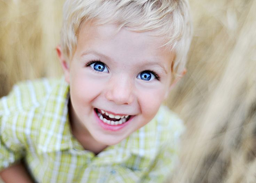

In [18]:
from fastdownload import download_url
dest = 'happy.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'sad human face'


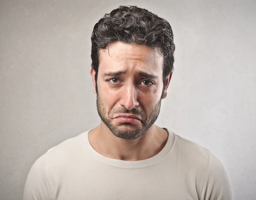

In [19]:
download_url(search_images('sad human face', max_images=1)[0], 'sad.jpg', show_progress=False)
Image.open('sad.jpg').to_thumb(256,256)

In [20]:
searches = 'sad human','happy human'
path = Path('happy_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} portrait photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sad human photo'
Searching for 'sad human portrait photo'
Searching for 'happy human photo'
Searching for 'happy human portrait photo'


In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


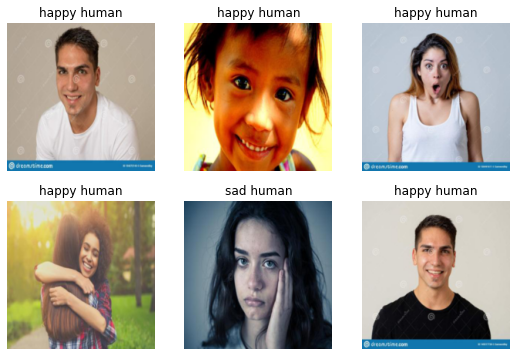

In [22]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\Joshua\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Joshua\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.068279,0.922589,0.369565,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.711560,0.750001,0.282609,00:08
1,0.578289,0.772349,0.239130,00:08
2,0.489299,0.748174,0.217391,00:08


In [24]:
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f"This is a: {is_happy}.")
print(f"Probability person is happy: {probs[0]:.4f}")

This is a: happy human.
Probability person is happy: 0.9219


In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
learn.export('model.pkl')